**Librerias**

In [1]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import resample
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import argrelextrema

**Funciones**

In [2]:
def record_a_vector(record):
    vector = np.squeeze(record.p_signal) # Quita las dimensiones innecesarias del array (de 2D a 1D)
    return vector

In [3]:
def grafica_vector(vector):
    plt.figure(figsize=(15, 5))
    plt.plot(vector)
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.title("Vector ECG")
    plt.grid(True)
    plt.show()

In [4]:
def remuestreo_inicial(vector_original, fs_original, fs_nueva):
    # Calcular la cantidad de muestras en el nuevo vector
    n_muestras_original = len(vector_original)
    n_muestras_nueva = int(n_muestras_original * fs_nueva / fs_original)

    # Remuestrear el vector
    vector_remuestreado = resample(vector_original, n_muestras_nueva)

    return vector_remuestreado

In [5]:
def normalizar_vector(vector):
    minimo = np.min(vector)
    maximo = np.max(vector)
    vector_normalizado = (vector - minimo) / (maximo - minimo)
    return vector_normalizado

In [6]:
def derivar_vector(vector):
    derivada = np.gradient(vector)
    return derivada



In [7]:
def eliminar_valores_negativos(vector):
    vector_sin_negativos = np.clip(vector, 0, None) # Los valores menores de 0 se reemplazan con 0
    return vector_sin_negativos

In [8]:
def media_latidos(indices):
    # Calcular las diferencias entre los índices consecutivos de los máximos
    diferencias = np.diff(indices)

    # Calcular la media de las diferencias
    media_diferencias = np.mean(diferencias)
    
    return media_diferencias

In [9]:
def comparar(a, b):
    return a > b

def encontrar_maximos(vector, umbral, distancia_minima):
    # Encontrar los índices de los máximos locales que superan el umbral
    indices_maximos = argrelextrema(vector, comparar, order=distancia_minima)

    # Filtrar los máximos locales para asegurar que superen el umbral
    indices_filtrados = [indice for indice in indices_maximos[0] if vector[indice] > umbral]

    return np.array(indices_filtrados)

In [10]:
def extraer_segmentos_10seg(vector, indices_maximos, media):
    segmentos = []
    ventana = int(media / 2)
    
    for indice in indices_maximos:
        inicio = indice - ventana
        fin = indice + ventana
        
        # Verificar si hay suficientes muestras a la izquierda y a la derecha del índice
        if inicio >= 0 and fin < len(vector):
            segmento = vector[inicio:fin]
            segmentos.append(segmento)
    
    return segmentos

In [11]:
def ajustar_longitud(segmentos, longitud_objetivo):
    segmentos_ajustados = []
    
    for segmento in segmentos:
        if len(segmento) < longitud_objetivo:
            # Rellenar con ceros si el segmento es más corto que la longitud objetivo
            segmento_ajustado = np.pad(segmento, (0, longitud_objetivo - len(segmento)), 'constant')
        else:
            # Si el segmento es más largo que la longitud objetivo, tomar los primeros 187 valores
            segmento_ajustado = segmento[:longitud_objetivo]
        
        segmentos_ajustados.append(segmento_ajustado)
    
    return segmentos_ajustados


In [12]:
def grafica_normalizado_latidos(vector_norm, indices):
    plt.figure(figsize=(15, 5))
    # Graficar el vector normalizado
    plt.plot(vector_norm)

    # Graficar los máximos locales encontrados
    plt.plot(indices, vector_norm[indices], 'ro')

    # Configurar la gráfica
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.title('Vector normalizado y máximos locales')

    # Mostrar la gráfica
    plt.show()

In [13]:
def proceso_extraccion_vector(archivo, inicio):
    #carga el archivo completo y extrae la derivación 0
    (rec, ann, longitud) = extrear_derivacion(archivo,0)

    graficar(rec, ann, inicio, inicio+10)
    
    #separa el segmento en el periodo de segundos de interes
    (rec2, ann2) = extraer_segmento(rec, ann, inicio, inicio+10)
    
    vector = record_a_vector(rec2)
    #grafica_vector(vector)
    return vector

In [14]:
def proceso_segmentacion(vector, fs, umbral=0.3, distancia_minima=20, grafica=0):
    if (grafica == 1):
        print("Gráfica del vector original recibido")
        grafica_vector(vector)
    
    #ajustamos la frecuencia de muestreo
    vector_125 = remuestreo_inicial(vector, fs, 125)
    
    if (grafica == 2):
        print("Gráfica del vector ajustado a una frecuencia de 125Hz")
        grafica_vector(vector_125)
    
    #normaliza los 10 segundos
    vector_norm_orig = normalizar_vector(vector_125)
    
    if (grafica == 3):
        print("Gráfica del vector normalizado")
        grafica_vector(vector_norm_orig)
    
    #deriva el vector
    vector_der = derivar_vector(vector_125)
     
    #elimina valores negativos
    vector_sin_ceros = eliminar_valores_negativos(vector_der)
    
    #normaliza el vector
    vector_norm = normalizar_vector(vector_sin_ceros)
    
    if (grafica == 4):
        print("Gráfica del vector después de derivar, valores >0, normalizar")
        grafica_vector(vector_norm)
    
    #umbral = 0.3  # Cambia este valor según el umbral deseado
    #distancia_minima = 10  # Cambia este valor según la distancia mínima deseada entre máximos
    indices_maximos = encontrar_maximos(vector_norm, umbral, distancia_minima)
    
    #calcula la media entre latidos
    media = media_latidos(indices_maximos)
    
    #extrae segmentos en los 10 segundos
    segmentos_extraidos = extraer_segmentos_10seg(vector_norm_orig, indices_maximos, media)
    
    if (grafica == 5):
        print("Gráfica de latidos con vector derivado")
        grafica_normalizado_latidos(vector_norm_orig, indices_maximos)
    
    #ajusta longitud de los segmentos
    segmentos_ajustados = ajustar_longitud(segmentos_extraidos, 187)
    
    #genera el dataframe de salida para el modelo
    df_segmentos = pd.DataFrame(segmentos_ajustados)
    

    return df_segmentos
    

**Ejecuta proceso**

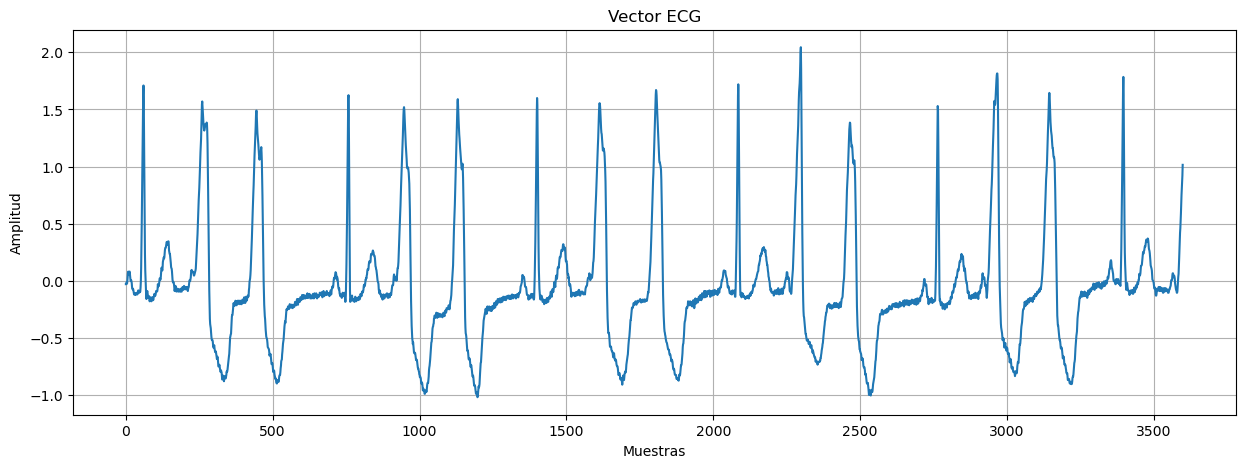

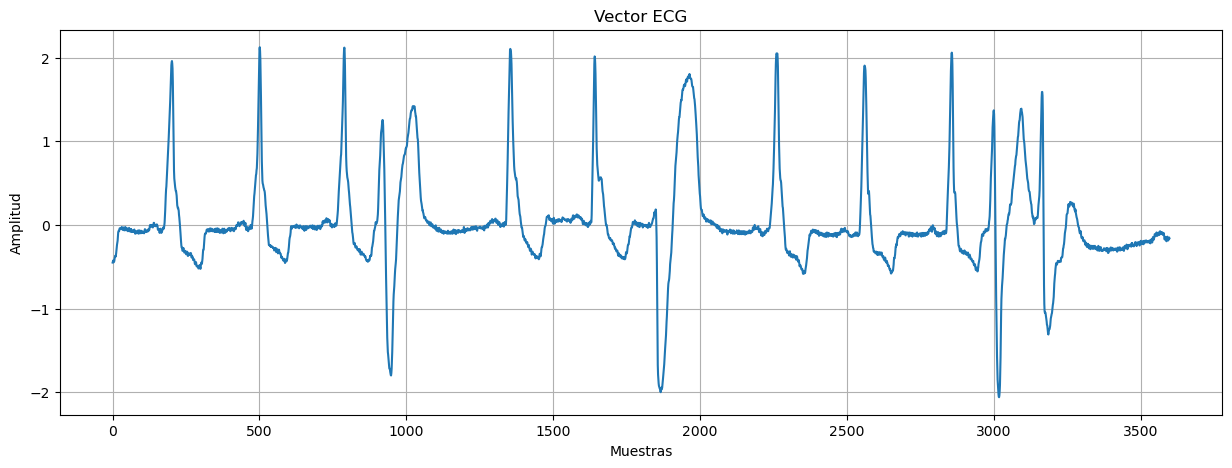

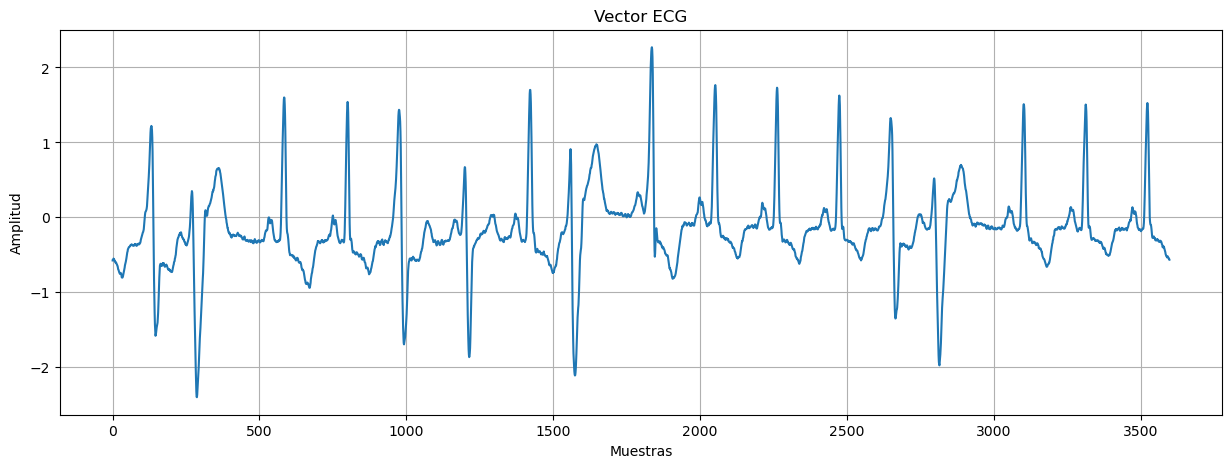

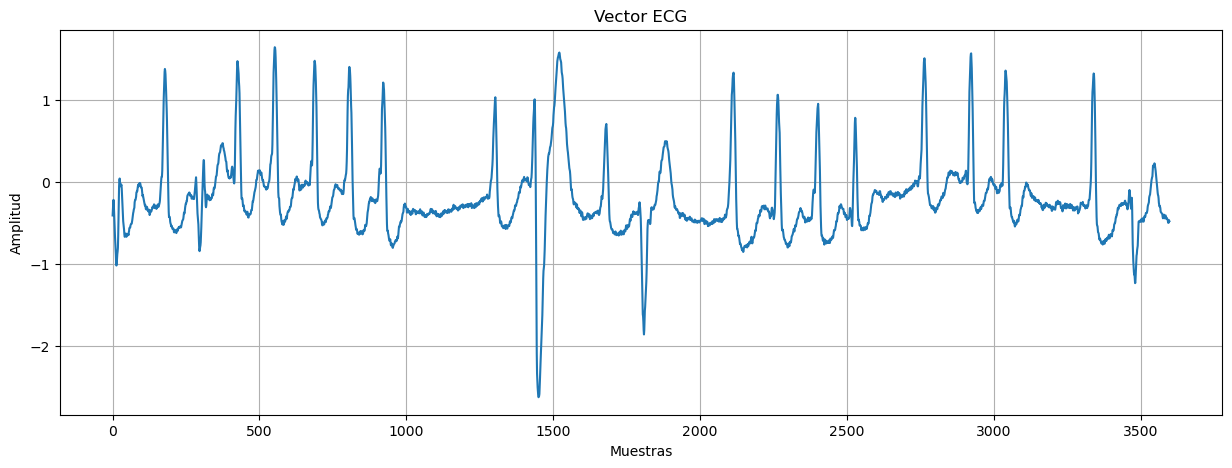

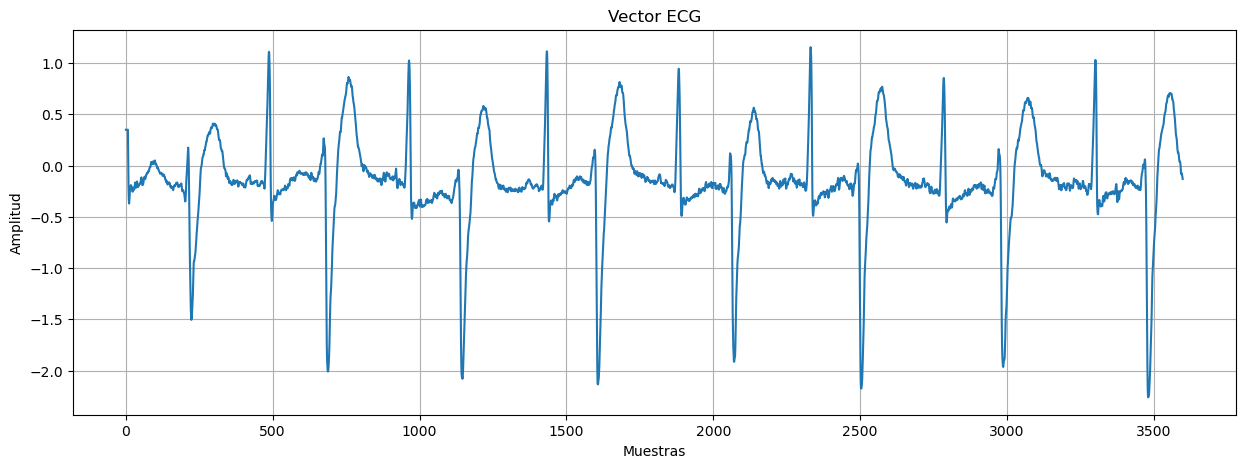

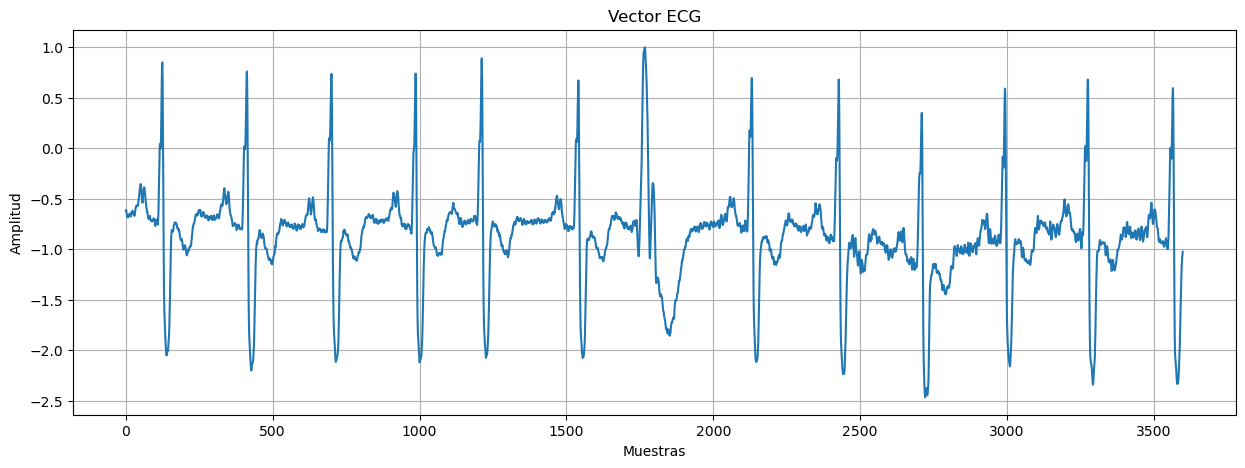

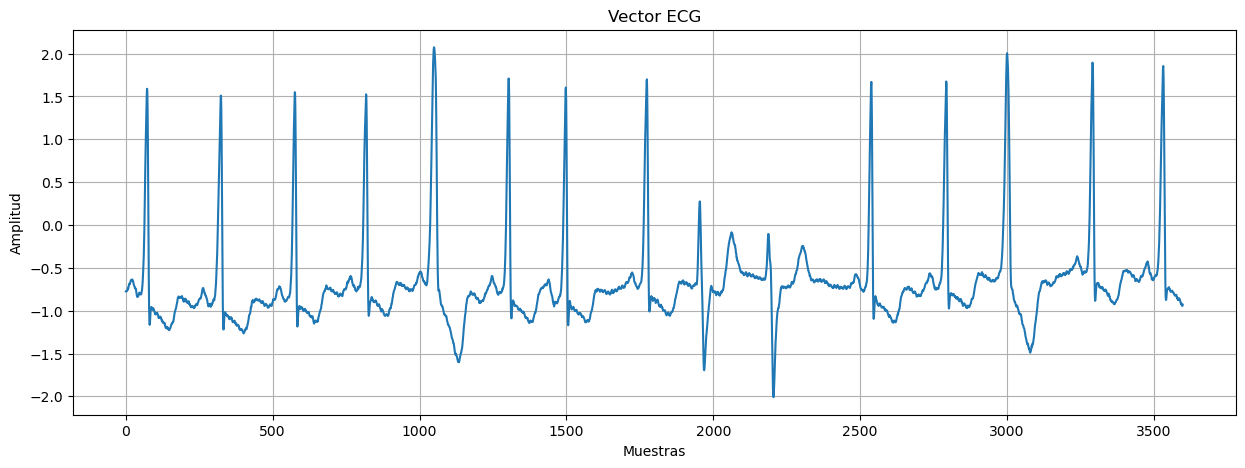

In [15]:
#carga archivos para el demo

vector1 = pd.read_csv('trazo001.csv').to_numpy().flatten()
vector2 = pd.read_csv('trazo002.csv').to_numpy().flatten()
vector3 = pd.read_csv('trazo003.csv').to_numpy().flatten()
vector4 = pd.read_csv('trazo004.csv').to_numpy().flatten()
vector5 = pd.read_csv('trazo005.csv').to_numpy().flatten()
vector6 = pd.read_csv('trazo006.csv').to_numpy().flatten()
vector7 = pd.read_csv('trazo007.csv').to_numpy().flatten()

grafica_vector(vector1)
grafica_vector(vector2)
grafica_vector(vector3)
grafica_vector(vector4)
grafica_vector(vector5)
grafica_vector(vector6)
grafica_vector(vector7)


In [16]:
#Procesa los vectores para obtener los latidos segmentados
latidos1 = proceso_segmentacion(vector1,360)
latidos2 = proceso_segmentacion(vector2,360)
latidos3 = proceso_segmentacion(vector3,360)
latidos4 = proceso_segmentacion(vector4,360)
latidos5 = proceso_segmentacion(vector5,360)
latidos6 = proceso_segmentacion(vector6,360)
latidos7 = proceso_segmentacion(vector7,360)

In [17]:
#carga el modelo y evalua "latidos"
modelo = load_model('./clasificador_ver5.h5')

def evalua(latidos):
    y_pred = modelo.predict(latidos)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(y_pred_classes)

Metal device set to: Apple M1 Pro


In [18]:
evalua(latidos1)
evalua(latidos2)
evalua(latidos3)
evalua(latidos4)
evalua(latidos5)
evalua(latidos6)
evalua(latidos7)


1/1 [==============================] - 0s 154ms/step


2023-05-06 18:19:00.233773: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[2 2 0 2 2 0 2 2 0 3 2 0 3 2 0]
1/1 [==============================] - 0s 54ms/step
[0 0 0 2 0 0 2 0 0 0 2 2]
1/1 [==============================] - 0s 54ms/step
[2 2 0 0 2 3 0 2 3 0 0 0 2 2 0 0]
1/1 [==============================] - 0s 46ms/step
[0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2]
1/1 [==============================] - 0s 48ms/step
[2 0 2 0 2 0 2 0 2 0 2 0 2 0]
1/1 [==============================] - 0s 51ms/step
[0 0 0 1 0 2 0 0 0 0 1]
1/1 [==============================] - 0s 52ms/step
[0 0 0 2 0 1 0 2 2 0 0 2 0]
